# Computational Social Science Project #2 

**Enter your Name:** Raffaeele Sindoni Saposhnik

*Semester:* Fall 2024


Below we fill in some of the code you might use to answer some of the questions. Here are some additional resources for when you get stuck:
* Code and documentation provided in the course notebooks  
* [Markdown cheatsheet](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) to help with formatting the Jupyter notebook
* Try Googling any errors you get and consult Stack Overflow, etc. Someone has probably had your question before!
* Send me a pull request on GitHub flagging the syntax that's tripping you up 

**INSTRUCTIONS:** For this project, copy all of the files in the Project 2 folder in the course repo into a "Project 2" subfolder within the "Computational Social Science Projects" directory that you created for the first project. You will work on the project locally, push your project to GitHub, and submit a link to the GitHub repo on bCourses by the project deadline. Be sure the final submission is in the main branch, which is what I'll pull down and re-run to grade. 

## 1. Introduction/Setup

#### a) Import relevant libraries
Here are some libraries you will need to get started. Along the way you may need to add more. Best practice is to add them here at the top of the script.

In [42]:
#
# import libraries you might need here 
#-----------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# use random seed for consistent results 
np.random.seed(273)

#### b) Read in and inspect data frame 
Read in the data frame and look at some of its attributes. Read in the data contained in the projoect folder: "Diabetes with Population Info by County 2017.csv".

In [44]:
#
# read in and inspect data frame
#
# Note that "CountyFips" needs to be a string so the leading 0 isn't dropped (only if you want to make choropleth map) 
diabetes = pd.read_csv("/Users/raffaelesindoni/Documents/git/Computational-Social-Science-Projects/Project 2/Diabetes with Population Info by County 2017.csv", 
                       dtype={"CountyFIPS": str}) 

In [45]:
#
# look at shape
#-----------
# look at the dimensions of the diabetes data frame
print('shape: ', diabetes.shape) 

shape:  (3220, 95)


In [46]:
#
# set pandas parameters
#-----------
# tells pandas how many rows to display when printing so results don't get truncated
pd.set_option('display.max_rows', 100)

# look at the data types for each column in diabetes df (likely be located under each row bc column names are long)
print('data types:', diabetes.dtypes)

data types: County                                                                                                                                                   object
State                                                                                                                                                    object
CountyFIPS                                                                                                                                               object
Diabetes_Number                                                                                                                                          object
Obesity_Number                                                                                                                                           object
Physical_Inactivity_Number                                                                                                                               object
sex and age_total population

Immediately, we see that some of the features that should be numeric (e.g., Diabetes_Number, Obesity_Number,  and Physical_Inactivity_Number) are not. We can check to see what the non-numeric values are in a column where we are expecting numeric information with a combination of `str.isnumeric()` and `unique()`.

In [47]:
#
# identify non-numeric features
#-----------
# Return rows where the column "Diabetes_Number" is non-numeric and get the unique values of these rows
# the "~" below in front of diabetes negates the str.isnumeric() so it only takes non-numeric values
print(diabetes[~diabetes['Diabetes_Number'].str.isnumeric()]['Diabetes_Number'].unique()) 

['Suppressed']


In [48]:
#
# Now do the same as above, but for "Obesity_Number"
#-----------
print(diabetes[~diabetes['Obesity_Number'].str.isnumeric()]['Obesity_Number'].unique()) 


['No Data']


In [49]:
#
# Now do the same as above, but for "Physical_Inactivity_Number" 
#-----------

print(diabetes[~diabetes['Physical_Inactivity_Number'].str.isnumeric()]['Physical_Inactivity_Number'].unique()) 



['No Data']


These values ("Suppresssed" and "No Data") contained in the two respective columns are coercing these features to objects instead of them being  integers. Let's drop those rows in the next section, and also recode "Physical_Inactivity_Number" feature to be an integer.

#### c. Recode variables

Convert 'Diabetes_Number', 'Obesity_Number', and 'Physical_Inactivity_Number' to integers below so we can use them in our analysis. Also fill in the object type we want to recode 'sex and age_total population_65 years and over_sex ratio (males per 100 females)' too (you'll have to scroll all the way over to the right).

In [50]:
#
# Recode variables
#-----------

# Diabetes
# ----------
# keep only useful info about our target feature, i.e., where diabetes_number not = 'Suppressed'
# note that the inside reference to the diabetes df identifies the column, and the outer calls specific rows according to a condition 
diabetes = diabetes[diabetes['Diabetes_Number']!="Suppressed"] 

# use the astype method on Diabetes_Number to convert it to an integer...if you are not sure, what does the astype() documentation tell you are possible arguments? 
diabetes['Diabetes_Number'] = diabetes['Diabetes_Number'].astype(int) 

# Obesity
# ----------
diabetes = diabetes[diabetes['Obesity_Number']!="No Data"] 

diabetes['Obesity_Number'] = diabetes['Obesity_Number'].astype(int) 


# Physical Inactivity
# ----------
diabetes = diabetes[diabetes['Physical_Inactivity_Number']!="No Data"] 
diabetes['Physical_Inactivity_Number'] = diabetes['Physical_Inactivity_Number'].astype(int) 


# Some final changes 
# ----------
# 65+ sex ratio had one "-" in it so let's drop that row first
diabetes = diabetes[diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)']!= "-"]

# change to numeric from string, since it originally included the "-", which made it a string
# you'll have to decide whether to make it integer or float 
diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'] = diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'].astype(float)

We should probably scale our count variables to be proportional to county population. We create the list 'rc_cols' to select all the features we want to rescale, and then use the `.div()` method to avoid typing out every single column we want to recode. 

In [51]:


# Scale to county populations
#-----------

# select count variables to recode to percentages; make sure we leave out ratios and our population variable 
# because these don't make sense to scale by population
rc_cols = [col for col in diabetes.columns if col not in ['County', 'State', 'CountyFIPS', 
                                                        'sex and age_total population_65 years and over_sex ratio (males per 100 females)', 
                                                        'sex and age_total population_sex ratio (males per 100 females)', 
                                                        'sex and age_total population_18 years and over_sex ratio (males per 100 females)',  
                                                        'race_total population']]
           
# recode all selected columns to numeric
diabetes[rc_cols] = diabetes[rc_cols].apply(pd.to_numeric, errors='coerce') 

# divide all columns but those listed above by total population to calculate rates
diabetes[rc_cols] = diabetes[rc_cols].div(diabetes['race_total population'], axis=0)

Let's check our work. Are all rates bounded by 0 and 1 as expected? 

In [52]:
#
# check
#-----------
# set pandas options
pd.set_option('display.max_columns', None)

# inspect recoded values
diabetes_summary = diabetes.describe().transpose() # note we use the transpose method rather than .T because this object is not a numpy array
  
# check recoding 
with pd.option_context('display.max_rows', 100, 'display.max_columns', None): 
    display(diabetes_summary.iloc[ : ,[0,1,3,7]]) # select which columns in the summary table we want to present

,count,mean,min,max
Diabetes_Number,3112.0,0.092857,0.019038,2.242079e-01
Obesity_Number,3112.0,0.251666,0.088946,4.767883e-01
Physical_Inactivity_Number,3112.0,0.200861,0.064949,3.922853e-01
sex and age_total population_65 years and over_sex ratio (males per 100 females),3112.0,84.275643,34.700000,2.200000e+02
race_total population,3112.0,103682.624036,228.000000,1.009805e+07
race_total population_one race,3112.0,0.976059,0.713126,1.000000e+00
race_total population_two or more races,3112.0,0.023941,0.000000,2.868743e-01
race_total population_one race_1,3112.0,0.976059,0.713126,1.000000e+00
race_total population_one race_white,3112.0,0.831107,0.038912,1.000000e+00
race_total population_one race_black or african american,3112.0,0.090215,0.000000,8.741228e-01


#### d. Check for duplicate columns

There are a lot of columns in this data frame. Let's see if there are any are duplicates. Note that Pandas will not allow them to have the same exact column name, so they will likely be distinct on column name but will be copies otherwise.

In [53]:
#
# Check for duplicate columns
#-----------
# I used Google to figure this out, and adapted this example for our purposes:  
# source: https://thispointer.com/how-to-find-drop-duplicate-columns-in-a-dataframe-python-pandas/ 
def getDuplicateColumns(df):
    '''
    Get a list of duplicate columns.
    It will iterate over all the columns in dataframe and find the columns whose contents are duplicate.
    :param df: Dataframe object
    :return: List of columns whose contents are duplicates.
    '''
    duplicateColumnNames = set()
    # Iterate over all the columns in dataframe
    for x in range(df.shape[1]):
        # Select column at xth index.
        col = df.iloc[:, x]
        # Iterate over all the columns in DataFrame from (x+1)th index till end
        for y in range(x + 1, df.shape[1]):
            # Select column at yth index.
            otherCol = df.iloc[:, y]
            # Check if two columns at x 7 y index are equal
            if col.equals(otherCol):
                duplicateColumnNames.add(df.columns.values[y])
    return list(duplicateColumnNames)

duplicateColumnNames = list(getDuplicateColumns(diabetes))
print('Duplicate Columns are as follows: ')
duplicateColumnNames

Duplicate Columns are as follows: 


['race_total population_one race_1',
 'race_total population_two or more races_1',
 'sex and age_total population',
 'hispanic or latino and race_total population',
 'sex and age_total population_65 years and over_1',
 'sex and age_total population_18 years and over_1']

In [54]:
#
# drop columns from duplicates list
#-----------
# now drop list of duplicate features from our df using the .drop() method
diabetes = diabetes.drop(columns=['race_total population_one race_1',
 'race_total population_two or more races_1',
 'sex and age_total population',
 'hispanic or latino and race_total population',
 'sex and age_total population_65 years and over_1',
 'sex and age_total population_18 years and over_1']) 

Finally, there are many states accounted for the in dataset. If we convert this column to a categorical variable, and create dummies, it will create a rather sparse matrix (many 0s in our dataset) becuase there will be 49 dummy variables. One alternative is to classify each state to a larger US region and use that variable instead of state. The following code will do that.

In [55]:
# Define a dictionary mapping states to regions
state_to_region = {
    'Alabama': 'Southeast',
    'Alaska': 'West',
    'Arizona': 'West',
    'Arkansas': 'South',
    'California': 'West',
    'Colorado': 'West',
    'Connecticut': 'Northeast',
    'Delaware': 'Northeast',
    'District of Columbia': 'Southeast',
    'Florida': 'Southeast',
    'Georgia': 'Southeast',f
    'Hawaii': 'West',
    'Idaho': 'West',
    'Illinois': 'Midwest',
    'Indiana': 'Midwest',
    'Iowa': 'Midwest',
    'Kansas': 'Midwest',
    'Kentucky': 'South',
    'Louisiana': 'South',
    'Maine': 'Northeast',
    'Maryland': 'Northeast',
    'Massachusetts': 'Northeast',
    'Michigan': 'Midwest',
    'Minnesota': 'Midwest',
    'Mississippi': 'South',
    'Missouri': 'Midwest',
    'Montana': 'West',
    'Nebraska': 'Midwest',
    'Nevada': 'West',
    'New Hampshire': 'Northeast',
    'New Jersey': 'Northeast',
    'New Mexico': 'West',
    'New York': 'Northeast',
    'North Carolina': 'Southeast',
    'North Dakota': 'Midwest',
    'Ohio': 'Midwest',
    'Oklahoma': 'South',
    'Oregon': 'West',
    'Pennsylvania': 'Northeast',
    'Rhode Island': 'Northeast',
    'South Carolina': 'Southeast',
    'South Dakota': 'Midwest',
    'Tennessee': 'South',
    'Texas': 'South',
    'Utah': 'West',
    'Vermont': 'Northeast',
    'Virginia': 'Southeast',
    'Washington': 'West',
    'West Virginia': 'South',
    'Wisconsin': 'Midwest',
    'Wyoming': 'West'
}

# Add a new 'Region' column based on the mapping
diabetes['Region'] = diabetes['State'].map(state_to_region)

# Print to verify'Region' column has been added
diabetes


,County,State,CountyFIPS,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population,race_total population_one race,race_total population_two or more races,race_total population_one race_white,race_total population_one race_black or african american,race_total population_one race_american indian and alaska native,race_total population_one race_american indian and alaska native_cherokee tribal grouping,race_total population_one race_american indian and alaska native_chippewa tribal grouping,race_total population_one race_american indian and alaska native_navajo tribal grouping,race_total population_one race_american indian and alaska native_sioux tribal grouping,race_total population_one race_asian,race_total population_one race_asian_asian indian,race_total population_one race_asian_chinese,race_total population_one race_asian_filipino,race_total population_one race_asian_japanese,race_total population_one race_asian_korean,race_total population_one race_asian_vietnamese,race_total population_one race_asian_other asian,race_total population_one race_native hawaiian and other pacific islander,race_total population_one race_native hawaiian and other pacific islander_native hawaiian,race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro,race_total population_one race_native hawaiian and other pacific islander_samoan,race_total population_one race_native hawaiian and other pacific islander_other pacific islander,race_total population_one race_some other race,race_total population_two or more races_white and black or african american,race_total population_two or more races_white and american indian and alaska native,race_total population_two or more races_white and asian,race_total population_two or more races_black or african american and american indian and alaska native,race alone or in combination with one or more other races_total population,race alone or in combination with one or more other races_total population_white,race alone or in combination with one or more other races_total population_black or african american,race alone or in combination with one or more other races_total population_american indian and alaska native,race alone or in combination with one or more other races_total population_asian,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander,race alone or in combination with one or more other races_total population_some other race,hispanic or latino and race_total population_hispanic or latino (of any race),hispanic or latino and race_total population_hispanic or latino (of any race)_mexican,hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican,hispanic or latino and race_total population_hispanic or latino (of any race)_cuban,hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino,hispanic or latino and race_total population_not hispanic or latino,hispanic or latino and race_total population_not hispanic or latino_white alone,hispanic or latino and race_total population_not hispanic or latino_black or african american alone,hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone,hispanic or latino and race_total population_not hispanic or latino_asian alone,hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone,hispanic or latino and race_total population_not hispanic or latino_some other race alone,hispanic or latino and race_total population_not hispanic or latino_two or more races,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races including some other race,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races excluding some

## 2. Exploratory Data Analysis

Make at least two figures (feel free to make more) and explain their relevance to the scientific problem. The goal here is to uncover interesting patterns in the data, learn more about the scope of the problem, and communicate these findings to your audience in clear ways.

#### A. Exploratory Data Analysis 1

#Below is my ranked analysis of the top-10 most obese counties in the US, as well as the top 10 least obese, by overall % pop rate
#As well as some other diabetes and physical activity numbers about those counties 

In [144]:
#
# EDA #1 and interpretations in this section 
#-----------


# Step 1: Add a ranking column based on Obesity_Number in the overall dataset
diabetes['Obesity_Rank'] = diabetes['Obesity_Number'].rank(ascending=False, method='min')

# Step 2: Select top 10 and bottom 10 counties by Obesity_Number
top_10_obesity = diabetes[['County', 'State', 'Obesity_Number', 'Diabetes_Number', 'Physical_Inactivity_Number']].sort_values(by='Obesity_Number', ascending=False).head(10)
bottom_10_obesity = diabetes[['County', 'State', 'Obesity_Number', 'Diabetes_Number', 'Physical_Inactivity_Number']].sort_values(by='Obesity_Number', ascending=True).head(10)

# Concatenate the top and bottom results
top_and_bottom_10 = pd.concat([top_10_obesity, bottom_10_obesity])

# Step 3: Merge the ranking from the full dataset with the top and bottom 10 table
final_table = pd.merge(top_and_bottom_10, diabetes[['County', 'State', 'Obesity_Rank']], on=['County', 'State'])

# Step 4: Reorder columns to make 'Obesity_Rank' the first column
final_table = final_table[['Obesity_Rank', 'County', 'State', 'Obesity_Number', 'Diabetes_Number', 'Physical_Inactivity_Number']]

# Step 5: Sort by the ranking
final_table = final_table.sort_values(by='Obesity_Rank', ascending=True)

# Display the table
print(final_table)

    Obesity_Rank                  County           State  Obesity_Number  \
0            1.0  Aleutians East Borough          Alaska        0.476788   
1            2.0         Okfuskee County        Oklahoma        0.438217   
2            3.0        Sunflower County     Mississippi        0.394316   
3            4.0          Candler County         Georgia        0.387457   
4            5.0   King And Queen County        Virginia        0.387408   
5            6.0            Macon County         Alabama        0.386690   
6            7.0           Warren County         Georgia        0.378975   
7            8.0            Gates County  North Carolina        0.377930   
8            9.0          Johnson County         Georgia        0.377903   
9           10.0        Jefferson County     Mississippi        0.375715   
19        3103.0           Cottle County           Texas        0.125077   
18        3104.0            Eagle County        Colorado        0.123554   
17        31

#### A. Exploratory Data Analysis 2

#Below compares median statistics from majority white vs. majority black counties

In [145]:
#
# EDA #2 and interpretations in this section 
#-----------

# Step 1: Define white-majority and black-majority counties
white_majority = diabetes[diabetes['race_total population_one race_white'] > 0.5]
black_majority = diabetes[diabetes['race_total population_one race_black or african american'] > 0.5]

# Step 2: Calculate median values for white-majority counties
white_medians = white_majority[['Obesity_Number', 'Diabetes_Number', 'Physical_Inactivity_Number']].median()

# Step 3: Calculate median values for black-majority counties
black_medians = black_majority[['Obesity_Number', 'Diabetes_Number', 'Physical_Inactivity_Number']].median()

# Step 4: Create a table with the median values
comparison_table = pd.DataFrame({
    'Metric': ['Obesity', 'Diabetes', 'Physical Inactivity'],
    'White Majority Counties': white_medians.values,
    'Black Majority Counties': black_medians.values
})

# Step 5: Display the table
print(comparison_table)



                Metric  White Majority Counties  Black Majority Counties
0              Obesity                 0.251334                 0.303244
1             Diabetes                 0.088165                 0.125656
2  Physical Inactivity                 0.198026                 0.242478


## 3. Prepare to Fit Models

### 3.1 Finalize Data Set

We've already cleaned up the data, but we can make a few more adjustments before partitioning the data and training models. Let's recode 'Region' to be a categorical variable using `pd.get_dummies` and drop 'State'. Also, we'll drop 'County' because 'CountyFIPS' is already a unique identifier for the county. 

In [146]:
#
# Drop and get dummies
#-----------

# create dummy features out of 'Region', which might be related to diabetes rates 
diabetes_clean = pd.get_dummies(diabetes, 
                               columns = ['Region'],  
                               drop_first = True) # drop the first as a reference 

# drop 'County' and 'State' variables
diabetes_clean = diabetes_clean.drop(labels = ['County', 'State'],
                               axis = 1) # which axis tells python we want to drop columns rather than index rows?

# look at first 10 rows of new data frame 
diabetes_clean.head(10) 

,CountyFIPS,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population,race_total population_one race,race_total population_two or more races,race_total population_one race_white,race_total population_one race_black or african american,race_total population_one race_american indian and alaska native,race_total population_one race_american indian and alaska native_cherokee tribal grouping,race_total population_one race_american indian and alaska native_chippewa tribal grouping,race_total population_one race_american indian and alaska native_navajo tribal grouping,race_total population_one race_american indian and alaska native_sioux tribal grouping,race_total population_one race_asian,race_total population_one race_asian_asian indian,race_total population_one race_asian_chinese,race_total population_one race_asian_filipino,race_total population_one race_asian_japanese,race_total population_one race_asian_korean,race_total population_one race_asian_vietnamese,race_total population_one race_asian_other asian,race_total population_one race_native hawaiian and other pacific islander,race_total population_one race_native hawaiian and other pacific islander_native hawaiian,race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro,race_total population_one race_native hawaiian and other pacific islander_samoan,race_total population_one race_native hawaiian and other pacific islander_other pacific islander,race_total population_one race_some other race,race_total population_two or more races_white and black or african american,race_total population_two or more races_white and american indian and alaska native,race_total population_two or more races_white and asian,race_total population_two or more races_black or african american and american indian and alaska native,race alone or in combination with one or more other races_total population,race alone or in combination with one or more other races_total population_white,race alone or in combination with one or more other races_total population_black or african american,race alone or in combination with one or more other races_total population_american indian and alaska native,race alone or in combination with one or more other races_total population_asian,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander,race alone or in combination with one or more other races_total population_some other race,hispanic or latino and race_total population_hispanic or latino (of any race),hispanic or latino and race_total population_hispanic or latino (of any race)_mexican,hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican,hispanic or latino and race_total population_hispanic or latino (of any race)_cuban,hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino,hispanic or latino and race_total population_not hispanic or latino,hispanic or latino and race_total population_not hispanic or latino_white alone,hispanic or latino and race_total population_not hispanic or latino_black or african american alone,hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone,hispanic or latino and race_total population_not hispanic or latino_asian alone,hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone,hispanic or latino and race_total population_not hispanic or latino_some other race alone,hispanic or latino and race_total population_not hispanic or latino_two or more races,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races including some other race,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races excluding some other race -

### 3.2 Partition Data, Feature Selection, and Standardization

Now, we will partition our data to prepare it for the training process. Ultimately we want to use a 60% train—20% validation—20% test in this case. More data in the training set lowers bias, but then increases variance in the validation/test sets. Balancing between bias and variance with choice of these set sizes is important as we want to ensure that there is enough data to train on to get good predictions, but also want to make sure our hold-out sets are representative enough.

Work through partitioning the data into the test/train/validation sets in the chunks below. Be sure to that if you are using Ridge or LASSO, you Standardize the data. Where you do this in the workflow matters so be clear about where you are doing this and why. 

In [147]:
#
# Partition data
#-----------

# import library
from sklearn.model_selection import train_test_split

# create y dataframe 
y = diabetes_clean['Diabetes_Number']

# create X dataframe (include everything except "Diabetes_Number", our target, 
# and "race alone or in combination with one or more other races_total population")
X = diabetes_clean.drop(columns=['Diabetes_Number',
                                 'race alone or in combination with one or more other races_total population'])



Investigate whether there are any features that you should remove prior to spliting and model fitting. You may also consider using plots and relationships you found in the EDA stage for this question. Be sure to justify your logic. 

In [148]:
#
# Feature selection
#-----------

#Remove variables that don't feel relevant 
diabetes_for_model = diabetes_clean.drop(columns=['Obesity_Rank',
 'White_Population_Rank',
 'Black_Population_Rank',
'sex and age_total population_18 years and over_sex ratio (males per 100 females)',
'sex and age_total population_median age (years)',
'sex and age_total population_sex ratio (males per 100 females)'])


In [149]:
#
# Training/test split
#-----------

# set the random seed
np.random.seed(10)


# split the data so that it returns 4 values: X_train, X_test, y_train, y_test
X_train, X_temp, y_train, y_temp = train_test_split(X,                 # specify training dataset
                                                    y,                 # specify test dataset
                                                    train_size=0.6,      # specify proportional split for training
                                                    test_size=0.4)       # specify proportional split for test


In [150]:
#
# Validation split
#-----------

# train_test_split returns 4 values: X_train, X_test, y_train, y_test, so how do we create a 60-20-20 train-validate-test split? 

# Step 2: Split the remaining 40% into 50% validation and 50% test (20% each of the total dataset)
X_validate, X_test, y_validate, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=10)

# Now, you have:
# X_train, y_train -> Training data (60%)
# X_validate, y_validate -> Validation data (20%)
# X_test, y_test -> Test data (20%)

In [151]:
#
# Standardization
#-----------
# Given that we want to only standardize non-dichotomous variables, we need to find a 
# solution that will loop over only the columns we want to standardize. The code below
# identifies all non-dichotomous variables in our dataset and only standardizes those.

# load library and create instance of Standard Scaler 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


# identify non-dichotomous columns we want to transform
columns = list(X_test.select_dtypes(include=['number']).loc[:, X_test.nunique() > 2])

# use loop to transform training data for only columns we want to transform
for column in columns:
    X_train[column] = scaler.fit_transform(X_train[column].values.reshape(-1, 1)).flatten()

# use loop to transform validation data for only columns we want to transform
for column in columns:
    X_validate[column] = scaler.fit_transform(X_validate[column].values.reshape(-1, 1)).flatten()

# use loop to transform test data for only columns we want to transform
for column in columns:
    X_test[column] = scaler.fit_transform(X_test[column].values.reshape(-1, 1)).flatten()

## 4. Train Models

In this section, train your models. 

**Note that if you use Lasso, you will likely need to specify a very low penalty (e.g., an alpha of 0.001) because of convergence problems.**

### 4.1 Describe models

Detail the basic logic and assumptions underlying each model, its pros/cons, and why it is a plausible choice for this problem.

**MODEL DESCRIPTION(S):** ...


###########
MODEL 1: Lasso Model: 

Description:

The Lasso model is a linear regression method that adds a regularization term, which penalizes regression coefficients (effectively shrinking some coefficients to zero). This makes it a solid choice for this diabetes dataset with a ton of census varibales which may or may not be effective in helping us predict what we're looking for here. 

Pros:

	•	Lasso is useful when you have many variables, but you suspect that not all of them are useful predictors for diabetes. Lasso automatically selects the most important features by shrinking some coefficients to zero, which simplifies the model and reduces the chance of overfitting. This is a great model to use here where we are not sure about what is relevant and what is not out of all the variables wer are presented with. 
	•	Prevents overfitting: The regularization can help prevent overfitting by discouraging the model from fitting too closely to the training data.

Cons:

	•	Bias in coefficient estimates: Since Lasso shrinks coefficients, it can introduce bias into the model. In some cases, this can mean that the estimated coefficients are further from the true values than they would be with standard linear regression.
	•		May exclude important features: If the penalty (alpha) is set too high, Lasso can shrink coefficients for important features down to zero, which could result in the model missing key relationships in the data. Hopefully making alpha smaller will fix this. 
	•	Handling collinearity: Lasso doesn’t handle collinearity as well as Ridge regression.




###########
MODEL 2: Linear Regression


Linear regression is a basic model that estimates the relationship between predictors and the dependent var by fitting a straight line. It assumes a linear relationship between features and the target, making it simple but sometimes limited in handling complex datasets.

Pros:

	•	Interpretable: Linear regression is straightforward and easy to interpret, making it easy to see the effect of each feature on the target.
	•	Low Bias: It has low bias since it captures direct, linear relationships well without adding complexity.

Cons:

	•	Sensitive to Outliers: Linear regression can be heavily influenced by outliers, which can distort predictions.
	•	Overfitting Risk with Many Features: Without regularization, linear regression can overfit the training data, especially when there are a lot of features.
	•	Limited to Linear Relationships: This model struggles when the relationship between features and the target is non-linear, which may reduce its performance on real-world data.


###########
MODEL 3: Ridge: 

Ridge regression is a regularized form of linear regression that adds a penalty term, shrinking coefficients towards zero, which helps prevent overfitting. Ridge regression is useful when we have some features with collinearity, since it stabilizes coefficient estimates without removing them entirely.

Pros:

	•	Handles Collinearity: Reduces impact of correlated features rather than eliminating them, which can lead to more stable and reliable predictions.
	•	Reduces Overfitting: Regularization helps prevent overfitting by shrinking coefficients - good when working with high-dimensional data.

Cons:

	•	Bias Introduction: Regularization term can introduce bias into  model 
	•	Does Not Perform Feature Selection: Unlike Lasso, Ridge does not zero out coefficients, so it does not simplify the model by removing unimportant features.





### 4.2 Train models

Train each model in the training set, and be sure to tune hyperparameters if appropriate. Report any relevant summary statistics from the training set, including how well each model fits the training data.

#### Model 1:  (Lasso Model)

In [152]:
#
# Model 1 training
#-----------

# Import necessary libraries
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Create the Lasso model with a low alpha (penalty)
lasso_reg = Lasso(alpha=0.001, random_state=10, max_iter=10000)  # alpha is the penalty term

# Step 2: Train the Lasso model on the training data
lasso_model = lasso_reg.fit(X_train, y_train)

In [153]:
#
# Model 2 training
#-----------


# Import necessary libraries
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Create a Linear Regression model
lin_reg = LinearRegression()

# Step 2: Train the model on the training data
lin_model = lin_reg.fit(X_train, y_train)

#### Model 3:  (enter name of model here) 

In [154]:
#
# Model 3 training
#-----------

# Import necessary libraries
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Create the Ridge model with regularization (alpha)
ridge_reg = Ridge(alpha=0.001, random_state=10)

# Step 2: Train the model on the training data
ridge_model = ridge_reg.fit(X_train, y_train)


## 5. Validate and Refine Models

### 5.1 Predict on the validation set
Using each of the models you trained, predict outcomes in the validation set. Evaluate how well each model did.

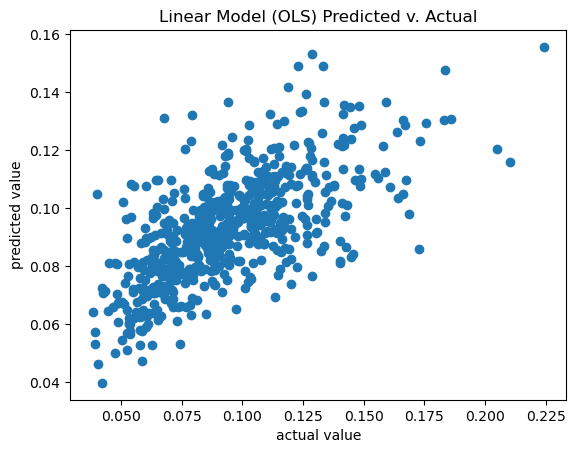

Model RMSE Comparison on Validation Data:
Lasso Model RMSE: 0.021768095145911943
Linear Regression Model RMSE: 0.023412447756641936
Ridge Model RMSE: 0.02337570557586697
Model R^2 Comparison on Validation Data:
Lasso Model R^2: 0.4384974779910269
Linear Regression Model R^2: 0.3504620956770653
Ridge Model R^2: 0.3524991925930925


In [155]:
#
# Predict on validation data
#-----------

#Step 1: Predict 

#(a) LASSSO
y_train_pred_lasso = lasso_model.predict(X_validate)

#(a) Regression
y_train_pred_lin = lin_model.predict(X_validate)

#(a) Ridge
y_train_pred_ridge = ridge_model.predict(X_validate)


# plot the residuals on a scatter plot
plt.scatter(y_validate, y_train_pred_lasso)                    # specify x and y of the scatter plot
plt.title('Linear Model (OLS) Predicted v. Actual')  # specify plot title
plt.xlabel('actual value')                           # specify x-axis label
plt.ylabel('predicted value')                        # specify y-axis label
plt.show()                                           # show plot


# Step 2: Define a function to calculate RMSE
def rmse(pred, actual):
 return np.sqrt(np.mean((pred - actual) ** 2))
    
# Step 3: Calculate RMSE for the Lasso model
rmse_lasso = rmse(y_train_pred_lasso, y_validate)

# Step 4: Calculate RMSE for the Linear Regression model
rmse_lin = rmse(y_train_pred_lin, y_validate)

# Step 5: Calculate RMSE for the Ridge model
rmse_ridge = rmse(y_train_pred_ridge, y_validate)

# Step 6: Print the RMSE values for each model
print("Model RMSE Comparison on Validation Data:")
print(f"Lasso Model RMSE: {rmse_lasso}")
print(f"Linear Regression Model RMSE: {rmse_lin}")
print(f"Ridge Model RMSE: {rmse_ridge}")

# Step 7: Calculate R^2 for the Lasso model
r2_lasso = lasso_model.score(X_validate, y_validate)

# Step 8: Calculate R^2 for the Linear Regression model
r2_lin = lin_model.score(X_validate, y_validate)

# Step 9: Calculate R^2 for the Ridge model
r2_ridge = ridge_model.score(X_validate, y_validate)

# Step 10: Print the R^2 values for each model
print("Model R^2 Comparison on Validation Data:")
print(f"Lasso Model R^2: {r2_lasso}")
print(f"Linear Regression Model R^2: {r2_lin}")
print(f"Ridge Model R^2: {r2_ridge}")




### 5.2 Predict on the test set

Now, choose your best performing model of the three, select out unimportant feature(s), retrain the model, and then predict on the test set. 

Removed 78 features with zero coefficients
Retained features after cleaning:
['CountyFIPS', 'Obesity_Number', 'Physical_Inactivity_Number', 'sex and age_total population_65 years and over_sex ratio (males per 100 females)', 'race_total population_one race_white', 'race_total population_two or more races_white and asian', 'hispanic or latino and race_total population_not hispanic or latino_black or african american alone', 'citizen -  voting age population_citizen -  18 and over population_female', 'sex and age_total population_20 to 24 years', 'sex and age_total population_45 to 54 years', 'sex and age_total population_65 to 74 years', 'sex and age_total population_65 years and over_female', 'Obesity_Rank', 'Black_Population_Rank']


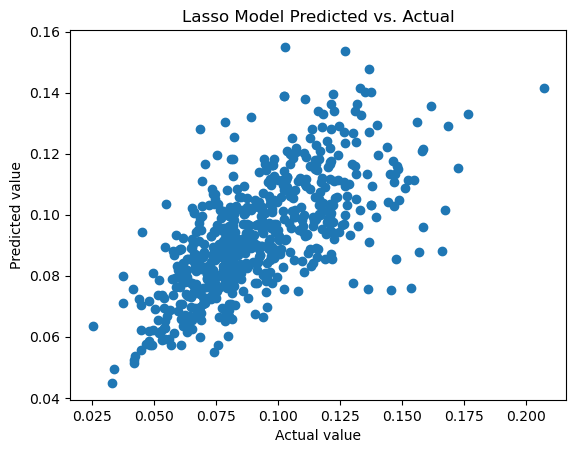

RMSE for Lasso Model V2 on Test Set: 0.01980005122210098
R^2 for Lasso Model V2 on Test Set: 0.44131802969326295


/var/folders/gz/_kv2w4cd1vs9kx6tvzl3yd300000gn/T/ipykernel_22897/4087646087.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


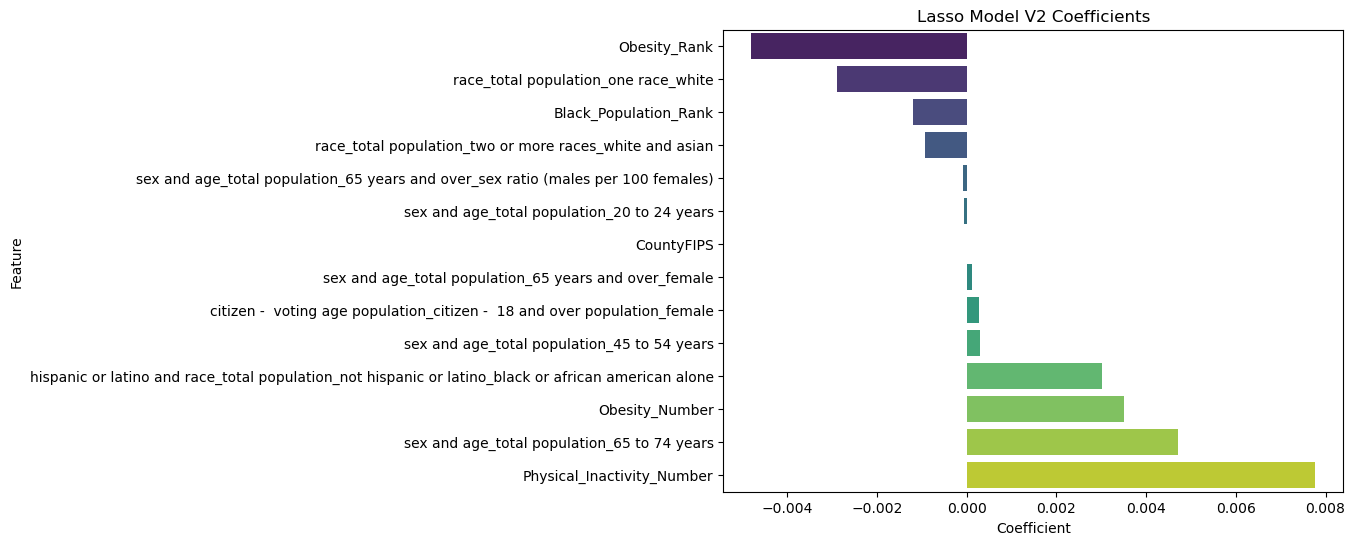

In [156]:
#
# Predict using your best model
#-----------

# We know that the LASSO Model did the best out of the models we tested.

#########
#########
######## STEP A: Select out unimportant features 

# Get the coefficients from the Lasso model
lasso_coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lasso_model.coef_
})

# Sort the coefficients by absolute value to see the most and least important features
lasso_coefficients = lasso_coefficients.sort_values(by='Coefficient', ascending=True)

# Identify features with zero coefficients
zero_coefficient_features = lasso_coefficients[lasso_coefficients['Coefficient'] == 0]['Feature']

# Drop these zero-coefficient features from the training data (X_train)
x_train_relevant_vars = X_train.drop(columns=zero_coefficient_features.tolist())

# Drop the same features from the test set (X_test) to keep it consistent with training
x_test_relevant_vars = X_test.drop(columns=zero_coefficient_features.tolist())

# Display the retained features
print(f"Removed {len(zero_coefficient_features)} features with zero coefficients")
print("Retained features after cleaning:")
print(x_train_relevant_vars.columns.tolist())


#########
#########
######## STEP B: Retrain the Lasso model

# Re-Create the Lasso model with the same low alpha (penalty)
lasso_reg_v2 = Lasso(alpha=0.001, random_state=10, max_iter=10000)

# Train the Lasso model on the cleaned training data
lasso_model_v2 = lasso_reg_v2.fit(x_train_relevant_vars, y_train)

#########
#########
######## STEP C: Predict on the Test Set

# Step 1: Predict using the cleaned test set
y_test_pred_lasso_v2 = lasso_model_v2.predict(x_test_relevant_vars)

# Step 2: Plot the residuals (predicted vs. actual) on a scatter plot
plt.scatter(y_test, y_test_pred_lasso_v2)           # Specify x (actual values) and y (predicted values)
plt.title('Lasso Model Predicted vs. Actual')       # Specify plot title
plt.xlabel('Actual value')                          # Specify x-axis label
plt.ylabel('Predicted value')                       # Specify y-axis label
plt.show()                                          # Show plot


# Step 3: Calculate RMSE for the Lasso model on the test set
rmse_lasso_v2 = rmse(y_test_pred_lasso_v2, y_test)


# Step 4: Print the RMSE for comparison
print(f"RMSE for Lasso Model V2 on Test Set: {rmse_lasso_v2}")


# Step 5: Calculate R^2 for the Lasso model on the test set
r2_lasso_v2 = lasso_model_v2.score(x_test_relevant_vars, y_test)

# Step 6: Print the R^2 for comparison
print(f"R^2 for Lasso Model V2 on Test Set: {r2_lasso_v2}")

# Stp 7 : Plot Coefficients 

# Get the coefficients from the Lasso V2 model
lasso_v2_coefficients = pd.DataFrame({
    'Feature': x_train_relevant_vars.columns,
    'Coefficient': lasso_model_v2.coef_
})

# Filter out zero coefficients and sort by coefficient value
non_zero_v2_coefficients = lasso_v2_coefficients[lasso_v2_coefficients['Coefficient'] != 0]
non_zero_v2_coefficients = non_zero_v2_coefficients.sort_values(by='Coefficient', ascending=True)

# Plot the coefficients
plt.figure(figsize=(8, 6))
sns.barplot(
    data=non_zero_v2_coefficients,
    y="Feature", x="Coefficient",
    palette="viridis"
)
plt.title("Lasso Model V2 Coefficients")
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.show()

### 5.3 Impement a cross-validation approach

Finally, implement a cross-validation approach for your best model and evaluate the results.

In [ ]:
#
# Run cross-validation
#-----------

from sklearn.model_selection import GridSearchCV


# Drop zero-coefficient features from the validation set (similar to training set)
x_validate_relevant_vars = X_validate.drop(columns=zero_coefficient_features.tolist())

# Step A: Specify the hyperparameters 

# Define a grid of hyperparameters for Lasso (V2 Model)
param_grid = {
    'alpha': np.arange(0.001, 1, 0.001),              # Range of alpha values to search
    'fit_intercept': [True, False],               # Whether to fit the intercept or not
    'selection': ['cyclic', 'random']             # Different selection strategies
}

# Step B: Execute the Grid Search

# Create a Lasso model and set up the GridSearchCV for tuning hyperparameters
lasso_grid_reg_v2 = GridSearchCV(
    estimator=lasso_reg_v2,              # The Lasso model to tune
    param_grid=param_grid,            # The hyperparameter grid to search
    cv=3,                             # 3-fold cross-validation
    scoring='neg_mean_squared_error'   # Use negative MSE as the scoring method
)

# Fit the model on the cleaned training data (x_train_relevant_vars)
lasso_grid_reg_v2.fit(x_train_relevant_vars, y_train)

# Step C: Evaluate the Results 

# Find the index of the best performing model
best_index = np.argmax(lasso_grid_reg_v2.cv_results_["mean_test_score"])

# Apply the best model to predict on the validation set (using cleaned validation features)
best_lasso_pred_v2 = lasso_grid_reg_v2.best_estimator_.predict(x_validate_relevant_vars)

# Print the best hyperparameters
print(f"Best hyperparameters: {lasso_grid_reg_v2.cv_results_['params'][best_index]}")

# Calculate and print the performance metrics
print('Best CV R^2:', max(lasso_grid_reg_v2.cv_results_["mean_test_score"]))
print('Validation R^2:', lasso_grid_reg_v2.score(x_validate_relevant_vars, y_validate))

# Calculate and print the RMSE on the validation set
validation_rmse_v2 = rmse(best_lasso_pred_v2, y_validate)
print(f'Validation RMSE (V2 Model): {validation_rmse_v2}')

## 6. Discussion Questions

In this section, insert responses for discussion questions here.

1. What is bias-variance tradeoff? Why is it relevant to machine learning problems like this one?

The bias-variance tradeoff is about finding the sweet spot between underfitting and overfitting. High bias means the model is too simple (underfitting), while high variance means it’s too complex (overfitting). For this project, balancing bias and variance is key because it determines how well our model generalizes to new data, which is the ultimate goal.

2. Define overfitting, and why it matters for machine learning. How can we address it?

Overfitting happens when a model learns the noise in the training data too well, leading to poor generalization on new data. It’s a problem because it gives us high accuracy in training but fails in real-world scenarios. We can address it by using regularization (like Lasso or Ridge), cross-validation, and keeping our models as simple as possible without losing predictive power.

3. Discuss your analysis in 2-3 paragraphs. Discuss your findings and recommendations. Which counties or regions would you prioritize for the pilot program? Would your answers change based on whether you want to take into account certain features such as race, gender, or age composition in the county? How confident would you be deploying this sort of model in a real-world application – why or why not?

Based on my analysis, the major predictors of diabetes rates in these counties are factors like obesity, physical inactivity, and some demographic characteristics, especially age and race composition. For a pilot program, I’d recommend zeroing in on counties with high obesity and inactivity rates, especially in more elderly areas, since these variables showed the strongest link to diabetes prevalence, suggesting that interventions targeting these areas could be the most impactful.

When we bring race into the picture, there’s an additional layer to consider. The data suggests disparities between Hispanic and white populations in terms of diabetes risk, so it might make sense to consider this context in our strategy. While age can be useful as an indicator (since older populations generally have a higher diabetes risk), using race directly as a targeting criterion is more complicated. We don’t want to reinforce existing inequalities or make assumptions about individual risk based on demographic averages. Instead, I’d focus primarily on modifiable health factors (like obesity, age, or activity levels) and use demographic information as a layer of context, acknowledging disparities without making race the main driver of targeting.

Overall, I feel fairly confident deploying this model in a real-world setting if it could be sucesfully validated with larger social theories or medical accounts that help us understand why, indeed, diabetes could be linked to certain race and age factors. We need the full story to move forward. Our R^2 value is decent too ~45% (: 